# Bài Test thực hành Mô hình dự đoán biến động giá cổ phiếu của FPT

## Bước 1: Khai báo thư viện

In [1]:
#Khai báo thư viện
import pandas as pd
import numpy as np
import datetime# Xử lý ngày tháng
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu huấn luyện tốt nhất
from tensorflow.keras.models import load_model #load model

#xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import Dense, LSTM, Dropout #đầu ra, LSTM, tránh overfitting

#độ chính xác của mô hình
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

## Bước 2: Đọc dữ liệu

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# đọc dữ liệu từ file csv
df=pd.read_csv('/content/drive/MyDrive/Test Online - Finpros/FPT.csv')

## Bước 3: Mô tả dữ liệu

In [5]:
#Định dạng thời gian theo đúng format
df['Date/Time']=pd.to_datetime(df['Date/Time'],format='%m/%d/%Y %H:%M')

In [6]:
#Kích thước dữ liệu
df.shape

(97406, 8)

In [7]:
#Dữ liệu 5 dòng đầu
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410,0
1,FPT,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190,0
2,FPT,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120,0
3,FPT,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120,0
4,FPT,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500,0


In [8]:
#Bỏ cột Ticker
df=df.drop(['Ticker'],axis=1)

In [9]:
#Kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date/Time      97406 non-null  datetime64[ns]
 1   Open           97406 non-null  float64       
 2   High           97406 non-null  float64       
 3   Low            97406 non-null  float64       
 4   Close          97406 non-null  float64       
 5   Volume         97406 non-null  int64         
 6   Open Interest  97406 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 5.2 MB


In [10]:
#Mô tả dữ liệu
df.describe()

,Date/Time,Open,High,Low,Close,Volume,Open Interest
count,97406,97406.000000,97406.000000,97406.000000,97406.000000,9.740600e+04,97406.0
mean,2020-01-21 05:08:51.739112192,45.071630,45.090138,45.051430,45.071631,8.044173e+03,0.0
min,2018-12-25 09:15:00,30.250000,30.250000,30.220000,30.250000,1.000000e+01,0.0
25%,2019-08-06 11:06:15,39.740000,39.740000,39.700000,39.740000,7.500000e+02,0.0
50%,2020-01-31 10:37:30,46.950000,46.950000,46.950000,46.950000,2.960000e+03,0.0
75%,2020-07-14 09:54:45,49.200000,49.250000,49.170000,49.200000,8.960000e+03,0.0
max,2020-12-22 14:46:00,58.400000,58.500000,58.400000,58.400000,1.255930e+06,0.0
std,NaN,6.359803,6.364950,6.354245,6.359799,1.753203e+04,0.0


## Bước 4. Tiền xử lý dữ liệu

In [11]:
#Lấy dữ liệu
df1=pd.DataFrame(df, columns=['Date/Time', 'Close'])
df1.index=df1['Date/Time']
df1=df1.drop(['Date/Time'],axis=1)

In [12]:
df1

,Close
Date/Time,
2018-12-25 09:15:00,30.89
2018-12-25 09:16:00,30.81
2018-12-25 09:17:00,30.74
2018-12-25 09:18:00,30.74
2018-12-25 09:19:00,30.74
...,...
2020-12-22 14:24:00,58.20
2020-12-22 14:25:00,58.20
2020-12-22 14:26:00,58.20


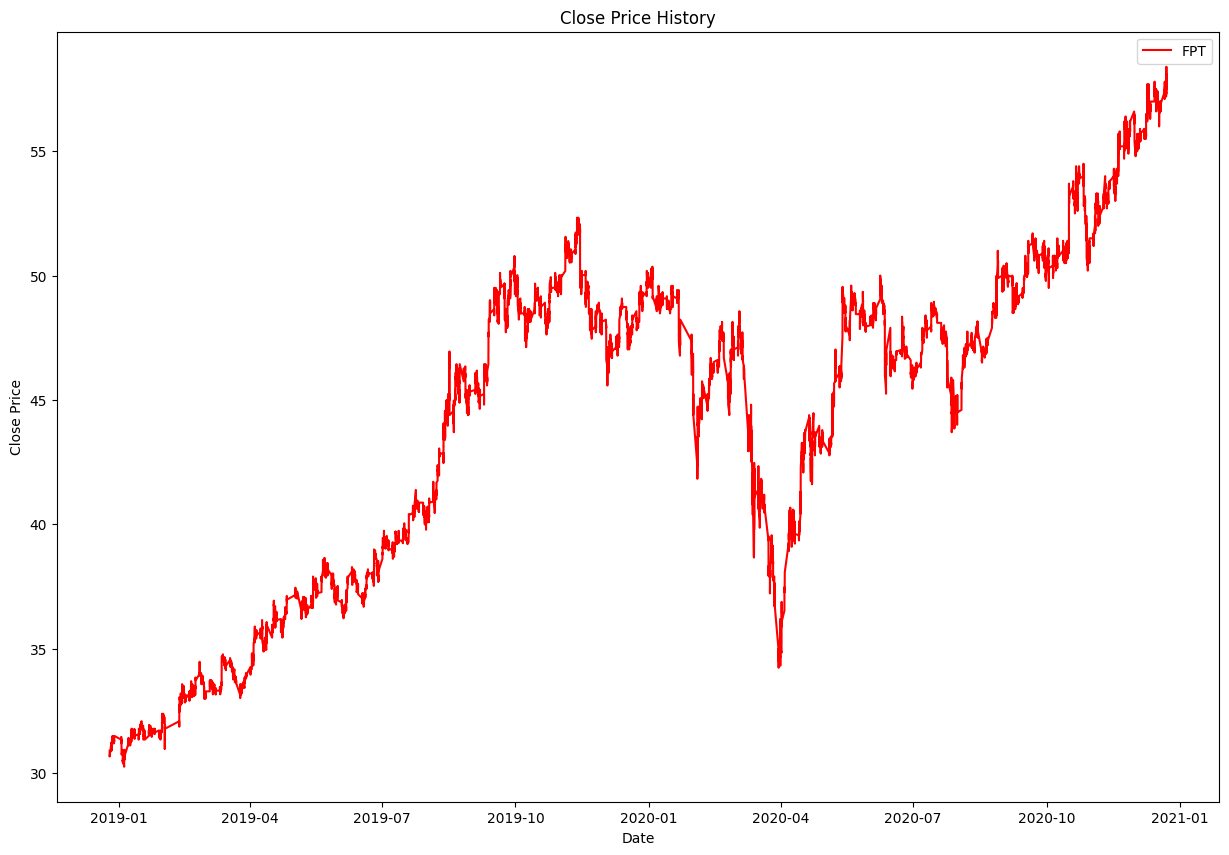

In [13]:
plt.figure(figsize=(15,10))
plt.plot(df1['Close'], label='FPT', color='r')
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend() #chú thích
plt.show()

In [14]:
#Chia tập dữ liệu
data=df1.values
train_data=data[:80000]
test_data=data[80000:]

data

array([[30.89],
       [30.81],
       [30.74],
       ...,
       [58.2 ],
       [58.1 ],
       [58.1 ]])

In [15]:
#Chuẩn hóa dữ liệu
scaler=MinMaxScaler(feature_range=(0,1))
scaler_train=scaler.fit_transform(data)

In [16]:
#Sử dụng giá của 50 ngày liên tục để dự đoán giá của ngày kế tiếp
x_train, y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(scaler_train[i-50:i])
  y_train.append(scaler_train[i])

In [17]:
#Xếp dữ liệu thành một mảng
x_train=np.array(x_train)
y_train=np.array(y_train)

#Xếp dữ liệu thành mảng 1 chiều
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train=np.reshape(y_train,(y_train.shape[0],1))

## Bước 5: Xây dựng mô hình huấn luyện

In [18]:
#Xây dụng mô hình
model_FPT=Sequential()
model_FPT.add(LSTM(units=128,return_sequences=True,input_shape=(x_train.shape[1],1)))
model_FPT.add(Dropout(0.5))
model_FPT.add(Dense(units=1))
model_FPT.compile(optimizer='adam',loss='mean_squared_error')

In [19]:
#Huấn luyện mô hình
save_model_FPT=ModelCheckpoint('best_model_FPT.h5',monitor='loss',verbose=1,save_best_only=True,mode='min')
model_FPT.fit(x_train,y_train,epochs=100,batch_size=32,validation_split=0.2,callbacks=[save_model_FPT])

Epoch 1/100
1997/1999 [============================>.] - ETA: 0s - loss: 0.0030
Epoch 1: loss improved from inf to 0.00297, saving model to best_model_FPT.h5
1999/1999 [==============================] - 19s 7ms/step - loss: 0.0030 - val_loss: 1.4932e-04
Epoch 2/100
  28/1999 [..............................] - ETA: 11s - loss: 9.3695e-04

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1997/1999 [============================>.] - ETA: 0s - loss: 6.4570e-04
Epoch 2: loss improved from 0.00297 to 0.00065, saving model to best_model_FPT.h5
1999/1999 [==============================] - 20s 10ms/step - loss: 6.4561e-04 - val_loss: 7.1314e-05
Epoch 3/100
1996/1999 [============================>.] - ETA: 0s - loss: 4.6542e-04
Epoch 3: loss improved from 0.00065 to 0.00047, saving model to best_model_FPT.h5
1999/1999 [==============================] - 19s 10ms/step - loss: 4.6557e-04 - val_loss: 7.1992e-05
Epoch 4/100
1995/1999 [============================>.] - ETA: 0s - loss: 4.5208e-04
Epoch 4: loss improved from 0.00047 to 0.00045, saving model to best_model_FPT.h5
1999/1999 [==============================] - 17s 9ms/step - loss: 4.5222e-04 - val_loss: 7.0953e-05
Epoch 5/100
1995/1999 [============================>.] - ETA: 0s - loss: 4.4787e-04
Epoch 5: loss improved from 0.00045 to 0.00045, saving model to best_model_FPT.h5
1999/1999 [==============================] - 1

In [32]:
#Dữ liệu train
y_train=scaler.inverse_transform(y_train) #giá thực
final_model_FPT=load_model('best_model_FPT.h5') #giá dự đoán
y_train_predict=final_model_FPT.predict(x_train) #giá dự đoán
# Extract the last prediction from each sequence and reshape to match y_test
y_train_predict = y_train_predict[:,-1,:].reshape(-1, 1)
y_train_predict=scaler.inverse_transform(y_train_predict) #giá dự đoán

2499/2499 [==============================] - 9s 3ms/step


## Bước 6: Sử dụng mô hình

In [22]:
#Xử lý dữ liệu test
data_test=df1[len(train_data)-50:].values
data_test=data_test.reshape(-1,1)
scaler_test=scaler.transform(data_test)

x_test=[]
for i in range(50,data_test.shape[0]):
  x_test.append(scaler_test[i-50:i,0])
x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#Dữ liệu test
y_test=data[80000:] #giá thực
y_test_predict=final_model_FPT.predict(x_test) #giá dự đoán
# Extract the last prediction from each sequence
y_test_predict = y_test_predict[:,-1,:]
y_test_predict=scaler.inverse_transform(y_test_predict) #giá dự đoán

544/544 [==============================] - 2s 3ms/step


## Độ chính xác của mô hình

<ipython-input-23-180f01be3c0b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán']=y_train_predict[:, 0]  # Take the first prediction for each input  #thêm dữ liệu
<ipython-input-23-180f01be3c0b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán']=y_test_predict[:, 0] #thêm dữ liệu


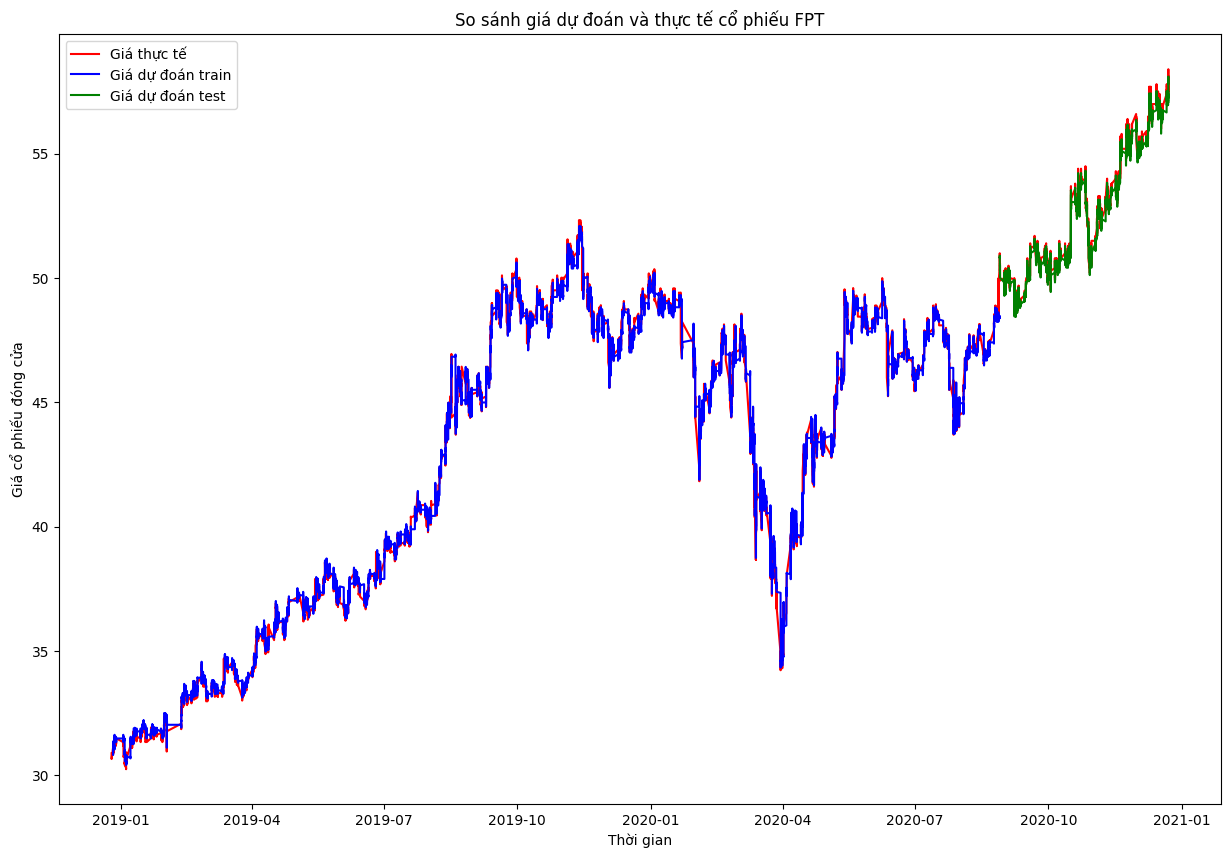

In [23]:
train_data1=df1[50:80000]
test_data1=df1[80000:]

plt.figure(figsize=(15,10))
plt.plot(df1, label='Giá thực tế', color='r') #đường giá thực
train_data1['Dự đoán']=y_train_predict[:, 0]  # Take the first prediction for each input  #thêm dữ liệu
plt.plot(train_data1['Dự đoán'], label='Giá dự đoán train', color='b') #đường giá dự báo train
test_data1['Dự đoán']=y_test_predict[:, 0] #thêm dữ liệu
plt.plot(test_data1['Dự đoán'], label='Giá dự đoán test', color='g') #đường giá dự báo test
plt.title('So sánh giá dự đoán và thực tế cổ phiếu FPT')
plt.xlabel('Thời gian')
plt.ylabel('Giá cổ phiếu đóng cửa')
plt.legend() #chú thích
plt.show()

- Nhận xét: Ta thấy đường dự đoán của cả tập train và tập test đều sát với giá thực tế. Các đường đi và độ tăng giảm tương đối chính xác

In [33]:
print(y_train.shape)
print(y_train_predict.shape)

(79950, 1)
(79950, 1)


In [34]:
#r2
print('Độ phù hợp tập test', r2_score(y_test,y_test_predict))

Độ phù hợp tập train -62.18536254208037
Độ phù hợp tập test 0.995727522329507


In [38]:
print('Phần trăm sai số tuyệt đối trung bình tập test', mean_absolute_percentage_error(y_test,y_test_predict))

Phần trăm sai số tuyệt đối trung bình tập test 0.002668985609054812


In [39]:
print('sai số tuyệt đối trung bình tập tes tập test', mean_absolute_error(y_test,y_test_predict))

sai số tuyệt đối trung bình tập tes tập test 0.14344897484431443


In [40]:
print('Sai số bình phương trung bình tập test', mean_squared_error(y_test,y_test_predict))

Sai số bình phương trung bình tập test 0.028367091429106976


Kết luận:
- Ta có thể thấy mô hình dự đoán sử dụng LSTM cho ra kết quả với độ chính xác khá cao.
- Có thể giúp ích cho các nhà đầu tư đưa ra quyết định khi tham gia vào thị trường chứng khoáng.
- Tuy nhiên còn có nhiều yếu tố khác nhau trên thị trường làm biến động giá cổ phiếu cũng như độ sai số của mô hình.
- Vì vậy các nhà đầu tư cũng chỉ nên tham khảo và đưa ra nhận định đúng đắn trước khi quyết định đầu tư.